# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

In [1]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_bogota')
backend = provider.get_backend('ibmq_lima')

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [2]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [3]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [4]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [5]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [6]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [7]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [8]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [9]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [10]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [11]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-11-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-11-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [12]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [13]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [14]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

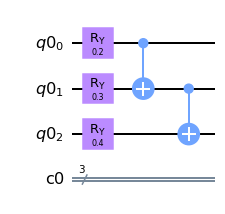

In [15]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [16]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

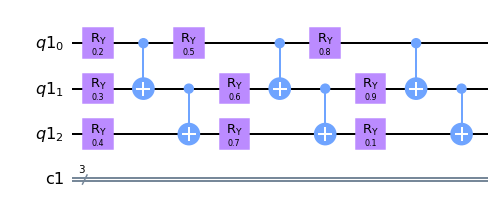

In [17]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [18]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

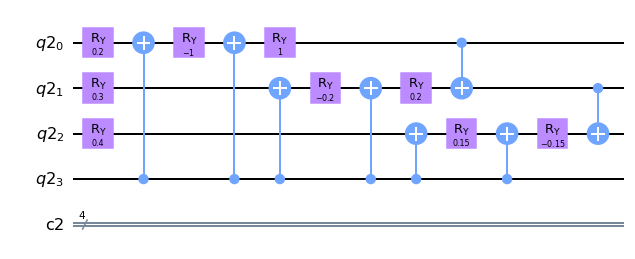

In [19]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [20]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [21]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

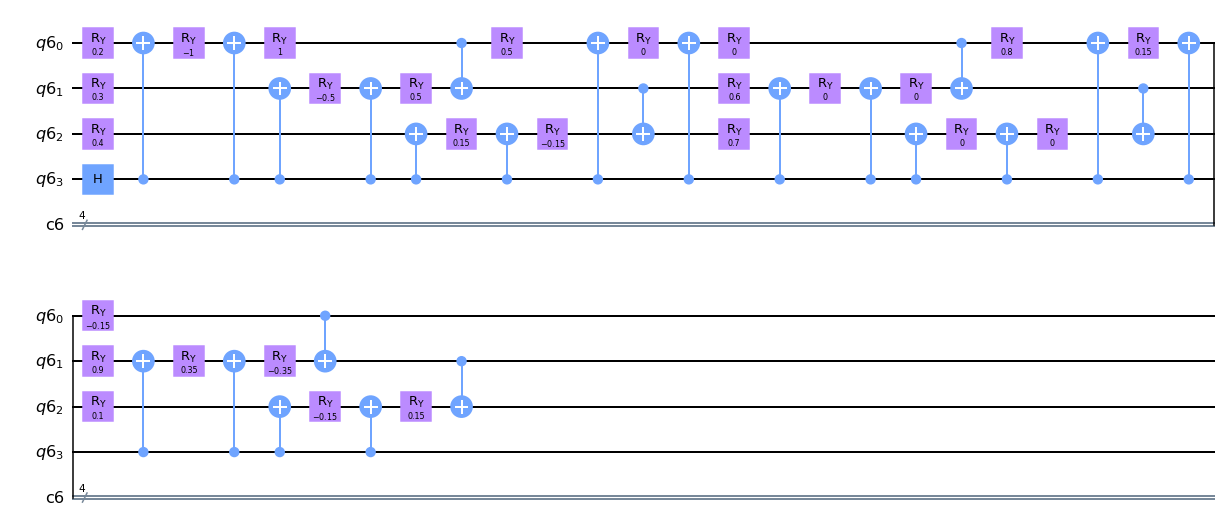

In [22]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.  

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [35]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

In [36]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0):
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'       
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
print(p_label)
print(lab_tst)
cir_tst.draw()

IXX
[0, 1, 1]


┌─────────┐     ┌──────────┐            ┌─┐   
q17_0: ┤ RY(1.2) ├──■──┤ RY(-π/2) ├────────────┤M├───
       ├─────────┤┌─┴─┐└──────────┘┌──────────┐└╥┘┌─┐
q17_1: ┤ RY(2.3) ├┤ X ├─────■──────┤ RY(-π/2) ├─╫─┤M├
       ├─────────┤└───┘   ┌─┴─┐    └───┬─┬────┘ ║ └╥┘
q17_2: ┤ RY(3.4) ├────────┤ X ├────────┤M├──────╫──╫─
       └─────────┘        └───┘        └╥┘      ║  ║ 
c17: 3/═════════════════════════════════╩═══════╩══╩═
                                        2       0  1

In [61]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi)
            cirs.append(cir_p)
            meas.append(meas_p)
            coef.append(w)
    return cirs,meas,coef

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs = collect_diag_circs(phi_b,block)

n=1
print(coefs[n])
print(meas[n])
circs[n].draw()

3.0
[1, 0, 0]


┌─────────────┐          ┌─┐      
q42_0: ┤ RY(0.42246) ├──■───────┤M├──────
       └┬────────────┤┌─┴─┐     └╥┘┌─┐   
q42_1: ─┤ RY(0.2741) ├┤ X ├──■───╫─┤M├───
       ┌┴────────────┤└───┘┌─┴─┐ ║ └╥┘┌─┐
q42_2: ┤ RY(0.24602) ├─────┤ X ├─╫──╫─┤M├
       └─────────────┘     └───┘ ║  ║ └╥┘
c42: 3/══════════════════════════╩══╩══╩═
                                 0  1  2

In [88]:
# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0.0:
            p_label = p.primitive.to_label()
            circ_x,meas_x = convert_to_circ('X' + p_label,psi)
            circ_y,meas_y = convert_to_circ('Y' + p_label,psi)
            cirs.append(circ_x)
            meas.append(meas_x)
            coef.append(w)
            cirs.append(circ_y)
            meas.append(meas_y)
            coef.append(1j*w)
    return cirs,meas,coef


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs = collect_off_circs(phi_a,phi_b,block)

n=0
print(coefs[n])
print(meas[n])
circs[n].draw()

1.0
[1, 1, 0, 0]


┌─────────────┐┌───┐┌───────────────┐┌───┐┌──────────────┐»
q67_0: ┤ RY(0.42246) ├┤ X ├┤ RY(-0.027243) ├┤ X ├┤ RY(0.027243) ├»
       └┬────────────┤└─┬─┘└───────────────┘└─┬─┘└────┬───┬─────┘»
q67_1: ─┤ RY(0.2741) ├──┼─────────────────────┼───────┤ X ├──────»
       ┌┴────────────┤  │                     │       └─┬─┘      »
q67_2: ┤ RY(0.24602) ├──┼─────────────────────┼─────────┼────────»
       └────┬───┬────┘  │                     │         │        »
q67_3: ─────┤ H ├───────■─────────────────────■─────────■────────»
            └───┘                                                »
c67: 4/══════════════════════════════════════════════════════════»
                                                                 »
«                                                                ┌─┐»
«q67_0: ───────────────────────────────────────────■─────────────┤M├»
«       ┌──────────────┐┌───┐┌─────────────┐     ┌─┴─┐           └╥┘»
«q67_1: ┤ RY(-0.30629) ├┤ X ├┤ RY(0.30629) ├─────┤ X ├────────────╫─»
«       └──────────────┘└─┬─┘└────┬───┬────┘┌────┴───┴─────┐┌───┐ ║ »
«q67_2: ──────────────────┼───────┤ X ├─────┤ RY(-0.18007) ├┤ X ├─╫─»
«                         │       └─┬─┘     └──────────────┘└─┬─┘ ║ »
«q67_3: ──────────────────■─────────■─────────────────────────■───╫─»
«                                                                 ║ »
«c67: 4/══════════════════════════════════════════════════════════╩═»
«                                                                 0 »
«                                             
«q67_0: ──────────────────────────────────────
«                                       ┌─┐   
«q67_1: ─────────────────■──────────────┤M├───
«       ┌─────────────┐┌─┴─┐┌──────────┐└╥┘┌─┐
«q67_2: ┤ RY(0.18007) ├┤ X ├┤ RY(-π/2) ├─╫─┤M├
«       └─┬──────────┬┘└┬─┬┘└──────────┘ ║ └╥┘
«q67_3: ──┤ RY(-π/2) ├──┤M├──────────────╫──╫─
«         └──────────┘  └╥┘              ║  ║ 
«c67: 4/═════════════════╩═══════════════╩══╩═
«                        3               1  2

In [118]:
# collect all the circuits 
def collect_circs(alpha,phi,blocks):
    circs = []
    meas = []
    coefs = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b = collect_diag_circs(phi[int(key[0])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
        else:
            circ_b, meas_b, coef_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
    return circs, meas, coefs

circs, meas, coefs = collect_circs(alpha,phi,blocks)

n=1
print(len(circs))
print(coefs[n])
print(meas[n])
circs[n].draw()

56
0.75
[1, 0, 0]


┌─────────────┐          ┌─┐      
q453_0: ┤ RY(0.42246) ├──■───────┤M├──────
        └┬────────────┤┌─┴─┐     └╥┘┌─┐   
q453_1: ─┤ RY(0.2741) ├┤ X ├──■───╫─┤M├───
        ┌┴────────────┤└───┘┌─┴─┐ ║ └╥┘┌─┐
q453_2: ┤ RY(0.24602) ├─────┤ X ├─╫──╫─┤M├
        └─────────────┘     └───┘ ║  ║ └╥┘
c453: 3/══════════════════════════╩══╩══╩═
                                  0  1  2

In [275]:
circs, meas, coefs = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix'):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192) 
        r = job.result().get_counts()
        
        
    return r

r = get_results(circs, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

In [278]:
def energy_from_results(r,meas,coefs):
    E = 0
    for l in range(len(r)):
        z_measure = 0
        total = 0
        for key in list(r[l].keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and meas[l][q] == 1:
                    n += 1
            z_measure += (-1)**n * r[l][key] 
            total += r[l][key]
        E += coefs[l]*z_measure/total
    return np.real(E)

energy_from_results(r,meas,coefs)

5.37896728515625

In [279]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(6.224275355427775+0j)

In [281]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
circs, meas, coefs = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

7.0

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [282]:
import copy

In [283]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        #Find E_A    
        circs_A, meas_A, coefs_A = collect_circs(alpha_k_A,phi_k_A,blocks)
        r_A = get_results(circs_A, method = method)
        E_A = energy_from_results(r_A,meas_A,coefs_A)
        #Find E_B    
        circs_B, meas_B, coefs_B = collect_circs(alpha_k_B,phi_k_B,blocks)
        r_B = get_results(circs_B, method = method)
        E_B = energy_from_results(r_B,meas_B,coefs_B)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        circs_f, meas_f, coefs_f = collect_circs(alpha_k,phi_k,blocks)
        r_f = get_results(circs_f, method = method)
        E_f = energy_from_results(r_f,meas_f,coefs_f)
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [289]:
out = SPSA(1000,method = 'matrix',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= -0.2554505511963856 E_A= 5.607356804151612 E_B= 5.811717245108721 E_f= 6.995528272652847
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -0.33656788716520486 E_A= 5.268905396036115 E_B= 5.519954475845262 E_f= 6.998983745620472
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 1.3824178633981048 E_A= 5.852074652977078 E_B= 4.86229145469231 E_f= 6.818753333286509
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 4.756865259891184 E_A= 6.70524010710618 E_B= 3.396956157692094 E_f= 5.321196133510744
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= -1.5436720529744636 E_A= 4.1570423025633785 E_B= 5.2067032949554335 E_f= 5.184355109357797
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 8.02430113034739 E_A= 8.007289959221655 E_B= 2.650508498626844 E_f= 3.138491343616361
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= -3.5823339349540615 E_A= 4.083521122409056 E_B= 6.438034444352894 E_f= 3.274529

k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -6.332482175236358 E_A= -9.516670261435648 E_B= -6.143043972371948 E_f= -11.927485197298775
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -18.579767998824316 E_A= -12.12578785746626 E_B= -2.2451060588664227 E_f= -10.303326227433312
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= 5.34421401491942 E_A= -5.896057607011342 E_B= -8.733111601105824 E_f= -10.191810007340592
k= 58 c_k= 0.26497441264651617 a_k= 0.02134820365090901 g= 5.2975812624814385 E_A= -6.50933069737052 E_B= -9.316777664316938 E_f= -10.269877180763434
k= 59 c_k= 0.2645249951151027 a_k= 0.021286550934731488 g= 1.6901531086871389 E_A= -7.432250629052693 E_B= -8.326426114691175 E_f= -10.455970293628292
k= 60 c_k= 0.26408374977289106 a_k= 0.021225947037019032 g= 3.03537777149157 E_A= -7.629807207678193 E_B= -9.232995095423744 E_f= -10.790745283563492
k= 61 c_k= 0.26365039764828974 a_k= 0.021166359715721263 g= 2.3440378883028745 E_A= -7.57786903

k= 110 c_k= 0.24858926511170829 a_k= 0.019069097746241874 g= -2.784629226302556 E_A= -9.853982442571981 E_B= -8.469524576621707 E_f= -11.590664059015054
k= 111 c_k= 0.24836418604633714 a_k= 0.019037577239396412 g= 0.3794734315700522 E_A= -9.273826635785806 E_B= -9.462321855702019 E_f= -11.566021084994784
k= 112 c_k= 0.24814130879388893 a_k= 0.01900636551187603 g= -9.387946536510812 E_A= -10.74388921921405 E_B= -6.084814538300352 E_f= -11.50556639357873
k= 113 c_k= 0.24792059261396104 a_k= 0.01897545706505521 g= -7.721286583499007 E_A= -10.668815757460065 E_B= -6.840283866413464 E_f= -11.45217654704568
k= 114 c_k= 0.24770199786906166 a_k= 0.018944846541571306 g= 0.7931846802132173 E_A= -8.587840277366254 E_B= -8.980787137302148 E_f= -11.509458084680057
k= 115 c_k= 0.24748548598546538 a_k= 0.01891452872059953 g= 0.09535673908413334 E_A= -9.049143702186422 E_B= -9.096342520014874 E_f= -11.500068153386444
k= 116 c_k= 0.24727101941578178 a_k= 0.01888449851332214 g= 3.4369371680517475 E_A= -

k= 164 c_k= 0.23883287851005275 a_k= 0.017705955017621747 g= -5.38130825311092 E_A= -10.052358660126021 E_B= -7.481891979645252 E_f= -11.24239711376333
k= 165 c_k= 0.238687169536964 a_k= 0.01768568795577825 g= -2.8329899065747433 E_A= -10.358333709237694 E_B= -9.005937024983467 E_f= -11.55918032843308
k= 166 c_k= 0.23854242379420307 a_k= 0.01766555872398643 g= -0.2657922641596816 E_A= -9.350934884891592 E_B= -9.224129423054793 E_f= -11.573580647804645
k= 167 c_k= 0.23839862920323973 a_k= 0.017645565614109175 g= -6.736478901294173 E_A= -11.136484310651579 E_B= -7.924549639201424 E_f= -11.770637217243424
k= 168 c_k= 0.2382557739077676 a_k= 0.017625706948624035 g= 4.84310718660687 E_A= -7.343126943500856 E_B= -9.650923445227438 E_f= -11.471876151714586
k= 169 c_k= 0.2381138462683289 a_k= 0.01760598107990712 g= -1.729706611932861 E_A= -10.313818428137134 E_B= -9.490084239570947 E_f= -11.58949242916221
k= 170 c_k= 0.23797283485710038 a_k= 0.01758638638953761 g= 2.669857203701448 E_A= -8.998

k= 218 c_k= 0.2320999974738524 a_k= 0.01677424849441828 g= -1.2127692786282323 E_A= -9.693754347331321 E_B= -9.130786854319364 E_f= -12.26374923634219
k= 219 c_k= 0.2319932241352903 a_k= 0.016759563730821866 g= 0.4313175508067422 E_A= -10.448289909389104 E_B= -10.64841540786469 E_f= -12.271043626739536
k= 220 c_k= 0.23188698381672643 a_k= 0.016744955447761316 g= 3.2206198401515547 E_A= -9.477349698845192 E_B= -10.970989340351295 E_f= -12.265102478784833
k= 221 c_k= 0.23178127146341995 a_k= 0.016730422918406034 g= 2.9795758215221593 E_A= -9.335066498795724 E_B= -10.716286243463864 E_f= -12.148378191407833
k= 222 c_k= 0.23167608209106294 a_k= 0.01671596542592795 g= -0.9723391943202059 E_A= -10.826685756926114 E_B= -10.376150286918742 E_f= -12.196483547781284
k= 223 c_k= 0.23157141078448806 a_k= 0.016701582263321663 g= -2.584751840747444 E_A= -10.878554241168406 E_B= -9.68144498058903 E_f= -12.189589897426307
k= 224 c_k= 0.23146725269640603 a_k= 0.016687272733228547 g= -3.568182020585424 

k= 272 c_k= 0.22699043857840095 a_k= 0.016075368264434862 g= -5.459819690725882 E_A= -10.978993811304182 E_B= -8.500340078990467 E_f= -12.153513297423858
k= 273 c_k= 0.22690662933816205 a_k= 0.016063974940957446 g= 6.04115150160596 E_A= -7.915682097390309 E_B= -10.657236746491478 E_f= -12.043595746291428
k= 274 c_k= 0.22682315618970433 a_k= 0.016052629696827414 g= 2.6508577547286256 E_A= -8.62170210616573 E_B= -9.82425395124073 E_f= -11.9618674758742
k= 275 c_k= 0.22674001657040857 a_k= 0.01604133216151698 g= -7.2899874368843856 E_A= -11.296831800011068 E_B= -7.990968055536596 E_f= -11.962521564510583
k= 276 c_k= 0.2266572079463908 a_k= 0.01603008196863675 g= -0.10551124144293814 E_A= -10.069361365524738 E_B= -10.02153159873991 E_f= -11.966045952963558
k= 277 c_k= 0.2265747278120774 a_k= 0.016018878755875255 g= -4.164289794408898 E_A= -10.996529355898062 E_B= -9.109483702500446 E_f= -11.929921403948665
k= 278 c_k= 0.22649257368978862 a_k= 0.01600772216493961 g= 1.417187446351366 E_A= -

k= 326 c_k= 0.22289004315802943 a_k= 0.015520881897408505 g= -1.5655581106058032 E_A= -10.135075051243913 E_B= -9.437180421565252 E_f= -11.762225537395443
k= 327 c_k= 0.22282131509420836 a_k= 0.01551164109518553 g= 1.1630093727132367 E_A= -9.41838500346804 E_B= -9.936671559257748 E_f= -11.755606227740317
k= 328 c_k= 0.22275281734417096 a_k= 0.015502433069694073 g= 2.0291825979447062 E_A= -9.464017141791727 E_B= -10.368029422987622 E_f= -11.893200936091509
k= 329 c_k= 0.22268454843958294 a_k= 0.015493257608503003 g= 0.019591092348144462 E_A= -8.918805610069704 E_B= -8.927530877175673 E_f= -11.894039926429341
k= 330 c_k= 0.22261650692588505 a_k= 0.015484114501177636 g= -3.203203864322466 E_A= -10.105056512586307 E_B= -8.678884402092379 E_f= -11.829285662569536
k= 331 c_k= 0.22254869136212244 a_k= 0.015475003539255199 g= 1.9098746634195363 E_A= -9.965604585827103 E_B= -10.815684799846487 E_f= -11.815822957725333
k= 332 c_k= 0.22248110032077717 a_k= 0.015465924516220633 g= -7.0845803335647

k= 380 c_k= 0.21947576364438018 a_k= 0.015064075237580469 g= 2.71946055413841 E_A= -9.926804569473498 E_B= -11.120515933114092 E_f= -12.53176200080245
k= 381 c_k= 0.21941766631600768 a_k= 0.015056343172115584 g= -2.6698065774819515 E_A= -10.95586268263864 E_B= -9.784257225146206 E_f= -12.663306644657327
k= 382 c_k= 0.21935973619491225 a_k= 0.015048634759752173 g= 5.542649605002767 E_A= -9.587561459688104 E_B= -12.019229770036587 E_f= -12.770339176229877
k= 383 c_k= 0.21930197236517004 a_k= 0.015040949868222755 g= 3.686412931203582 E_A= -10.235758455145152 E_B= -11.85263370867598 E_f= -12.812125764089599
k= 384 c_k= 0.21924437391824317 a_k= 0.015033288366332798 g= 1.43658506394889 E_A= -10.404592494979592 E_B= -11.03451888083114 E_f= -12.743386065440532
k= 385 c_k= 0.21918693995290123 a_k= 0.015025650123949338 g= -3.2963305285584 E_A= -11.335320266261817 E_B= -9.890295063005727 E_f= -12.829613894272384
k= 386 c_k= 0.2191296695751437 a_k= 0.015018035011989722 g= -0.911223450925894 E_A= -

k= 434 c_k= 0.21655717448691097 a_k= 0.014677417303624403 g= -1.8529804494153108 E_A= -11.398143371675658 E_B= -10.595590950665926 E_f= -13.477631388039175
k= 435 c_k= 0.21650695692514868 a_k= 0.014670796660096344 g= 0.946234774576061 E_A= -11.0399922680076 E_B= -11.449725091168034 E_f= -13.461022053289538
k= 436 c_k= 0.21645686601444106 a_k= 0.014664193820844652 g= 1.8360304028660508 E_A= -10.844433076047567 E_B= -11.6392758498708 E_f= -13.550142688873764
k= 437 c_k= 0.21640690114664293 a_k= 0.014657608698319708 g= -5.532841196614425 E_A= -12.8654405527765 E_B= -10.470750516984877 E_f= -13.65169043562859
k= 438 c_k= 0.2163570617179095 a_k= 0.0146510412055966 g= 0.5944364767401155 E_A= -11.259982625879175 E_B= -11.51720368485005 E_f= -13.664627816072947
k= 439 c_k= 0.2163073471286559 a_k= 0.0146444912563693 g= 1.580029737709488 E_A= -11.032313839274119 E_B= -11.71585792117077 E_f= -13.72278311945786
k= 440 c_k= 0.21625775678351783 a_k= 0.014637958764944881 g= -0.9404488518468105 E_A= -

k= 488 c_k= 0.21401282340311154 a_k= 0.014343389587992568 g= 1.6226751003772792 E_A= -12.093158004929776 E_B= -12.787704564325114 E_f= -14.01501715425713
k= 489 c_k= 0.2139686700366993 a_k= 0.014337618932776991 g= 1.10249982213928 E_A= -12.021782728594998 E_B= -12.493583569912676 E_f= -13.975897471031363
k= 490 c_k= 0.21392461576892882 a_k= 0.014331862122056118 g= -1.8862845970386866 E_A= -12.498615984592304 E_B= -11.691570569287604 E_f= -13.99452146212866
k= 491 c_k= 0.21388066017622928 a_k= 0.014326119095080895 g= 2.5775662112620004 E_A= -11.72060228827244 E_B= -12.823185414097757 E_f= -14.069055783846204
k= 492 c_k= 0.21383680283769652 a_k= 0.014320389791489158 g= 2.69535078177738 E_A= -11.696368774824645 E_B= -12.849099162227366 E_f= -14.042935020774705
k= 493 c_k= 0.21379304333507107 a_k= 0.01431467415130243 g= 5.836367184461833 E_A= -10.977181436136966 E_B= -13.472730840911037 E_f= -14.078955765716897
k= 494 c_k= 0.213749381252716 a_k= 0.014308972114922715 g= -1.458375208882983 E

k= 542 c_k= 0.21176062424310133 a_k= 0.014050191802669927 g= -0.04496077907790533 E_A= -11.545647108600924 E_B= -11.526605263312938 E_f= -14.128012364018389
k= 543 c_k= 0.21172127586789022 a_k= 0.014045090489919403 g= -4.589634285244776 E_A= -13.125688578999688 E_B= -11.182242125721615 E_f= -14.101521173244171
k= 544 c_k= 0.21168200704927512 a_k= 0.014040000224182966 g= -0.8375580933225629 E_A= -12.479579642715874 E_B= -12.124987686286106 E_f= -14.090589972037716
k= 545 c_k= 0.2116428174808709 a_k= 0.014034920961698066 g= -3.63940744192573 E_A= -12.362357218982362 E_B= -10.821848329042341 E_f= -14.001974347120411
k= 546 c_k= 0.21160370685803084 a_k= 0.014029852658953828 g= 1.1925357219693822 E_A= -11.871104690637006 E_B= -12.375794649295685 E_f= -14.030511401753607
k= 547 c_k= 0.2115646748778336 a_k= 0.014024795272689163 g= -3.8352149048532094 E_A= -13.165852087089569 E_B= -11.543060098225787 E_f= -14.035785218352904
k= 548 c_k= 0.21152572123907018 a_k= 0.014019748759890883 g= -0.82548

k= 596 c_k= 0.20974256938297772 a_k= 0.013789517725522909 g= 2.2535885064703636 E_A= -11.377080879446702 E_B= -12.322427766804784 E_f= -14.22707183229662
k= 597 c_k= 0.2097071179786167 a_k= 0.013784956021470169 g= 3.479054818809836 E_A= -11.699681769826556 E_B= -13.158846888511015 E_f= -14.203499598442587
k= 598 c_k= 0.20967173178514986 a_k= 0.013780403319396126 g= 4.439764458090071 E_A= -11.19722809162995 E_B= -13.059014296921756 E_f= -14.200147345874774
k= 599 c_k= 0.20963641057405918 a_k= 0.013775859586798566 g= -2.156263244591198 E_A= -12.759319479027118 E_B= -11.855256905329371 E_f= -14.220664660630822
k= 600 c_k= 0.2096011541180064 a_k= 0.013771324791345666 g= -1.0749197504452903 E_A= -12.68385715788822 E_B= -12.233248317333075 E_f= -14.219234460803328
k= 601 c_k= 0.2095659621908253 a_k= 0.013766798900874818 g= 1.7517130858374972 E_A= -12.003001536303989 E_B= -12.737200412935579 E_f= -14.267962671529206
k= 602 c_k= 0.20953083456751354 a_k= 0.013762281883391469 g= 0.04686545644540

k= 650 c_k= 0.20791619154587687 a_k= 0.013555311777631168 g= 1.2033932223191288 E_A= -12.158004449788374 E_B= -12.658414321221802 E_f= -14.221874974775634
k= 651 c_k= 0.20788396144333432 a_k= 0.013551193554979971 g= 1.1072895564404435 E_A= -12.618431621344126 E_B= -13.07880710025947 E_f= -14.267208500788286
k= 652 c_k= 0.20785178572027052 a_k= 0.013547082796837265 g= 0.9787166866959369 E_A= -12.594451625727151 E_B= -13.001307647815105 E_f= -14.285499254537367
k= 653 c_k= 0.20781966420186904 a_k= 0.01354297947844509 g= 0.1529451860349238 E_A= -11.806134252968299 E_B= -11.86970428737444 E_f= -14.286246099965242
k= 654 c_k= 0.20778759671414168 a_k= 0.013538883575164739 g= -1.78068533354621 E_A= -12.4237977911951 E_B= -11.683789139271726 E_f= -14.293260604976426
k= 655 c_k= 0.20775558308392328 a_k= 0.013534795062475995 g= 1.6606203606840941 E_A= -11.9688175172163 E_B= -12.658823819846218 E_f= -14.32797484643158
k= 656 c_k= 0.20772362313886658 a_k= 0.013530713915976387 g= -1.143119574655759

k= 704 c_k= 0.20624949341125984 a_k= 0.013343030843532541 g= -3.857732289379116 E_A= -13.319851962150597 E_B= -11.728541301349193 E_f= -14.105897076246674
k= 705 c_k= 0.2062199686610309 a_k= 0.013339283012698969 g= 4.760188908948207 E_A= -10.577387042585613 E_B= -12.540679057833385 E_f= -13.9609020891299
k= 706 c_k= 0.20619048991849742 a_k= 0.013335541463114317 g= 2.937609550372243 E_A= -11.430364055007338 E_B= -12.641778359768358 E_f= -14.053509185855377
k= 707 c_k= 0.2061610570470442 a_k= 0.013331806175512943 g= 1.1125115260732923 E_A= -12.391127911828825 E_B= -12.849841016213405 E_f= -14.024927759563212
k= 708 c_k= 0.2061316699106538 a_k= 0.013328077130715021 g= -1.3768054172162343 E_A= -12.756633188316368 E_B= -12.189026788730734 E_f= -14.099847968625845
k= 709 c_k= 0.2061023283739033 a_k= 0.01332435430962605 g= 1.740909677450294 E_A= -12.037981909341935 E_B= -12.755592985364268 E_f= -14.109637325101856
k= 710 c_k= 0.20607303230196078 a_k= 0.01332063769323634 g= 1.382996254433579 E

k= 758 c_k= 0.20471778406938132 a_k= 0.013149184224733476 g= -5.470350564666702 E_A= -13.376249170201685 E_B= -11.136493078839173 E_f= -13.960293569560312
k= 759 c_k= 0.20469056204905828 a_k= 0.013145749993095038 g= -1.9454540513588214 E_A= -12.241076276353963 E_B= -11.444644109927454 E_f= -13.975562071627827
k= 760 c_k= 0.20466337943631244 a_k= 0.013142321113793145 g= 1.956774104525541 E_A= -11.980385870185703 E_B= -12.781345872237026 E_f= -13.969203416901726
k= 761 c_k= 0.20463623612242432 a_k= 0.013138897571560183 g= 2.4969049633572897 E_A= -11.87244592373145 E_B= -12.89436039104512 E_f= -13.942810657442648
k= 762 c_k= 0.20460913199911662 a_k= 0.013135479351191795 g= -0.02355142084872783 E_A= -11.381919384549255 E_B= -11.372281712994846 E_f= -13.94294671335497
k= 763 c_k= 0.20458206695855174 a_k= 0.013132066437546538 g= 2.332169915409926 E_A= -11.384248553065063 E_B= -12.33848883665129 E_f= -13.950233457180133
k= 764 c_k= 0.20455504089332952 a_k= 0.013128658815545544 g= -1.543572828

k= 812 c_k= 0.2033016232369016 a_k= 0.012971035186914202 g= 2.4598616461088656 E_A= -11.612426106861529 E_B= -12.612613838045787 E_f= -13.811737002108707
k= 813 c_k= 0.20327638391063232 a_k= 0.012967869600710736 g= 0.47098468013256706 E_A= -12.552009147829782 E_B= -12.74348927313909 E_f= -13.80178207311023
k= 814 c_k= 0.20325117869950363 a_k= 0.012964708625066993 g= 5.653624612962927 E_A= -10.751644796869243 E_B= -13.049856529887723 E_f= -13.784182942211961
k= 815 c_k= 0.203226007515629 a_k= 0.012961552247691495 g= -2.0234715678405863 E_A= -12.395542128958049 E_B= -11.573098032850783 E_f= -13.816762554387733
k= 816 c_k= 0.20320087027145553 a_k= 0.012958400456340375 g= -1.1368654560249807 E_A= -12.54040961568743 E_B= -12.078385515595768 E_f= -13.790790664374065
k= 817 c_k= 0.20317576687976258 a_k= 0.012955253238817114 g= 0.6620528335325675 E_A= -11.843895930828086 E_B= -12.112922115163885 E_f= -13.79107772741676
k= 818 c_k= 0.20315069725365983 a_k= 0.012952110582972312 g= -1.63012771580

k= 866 c_k= 0.20198543896132912 a_k= 0.01280640069147025 g= 1.983653004432923 E_A= -11.536031786787543 E_B= -12.33736983248223 E_f= -13.762869015137937
k= 867 c_k= 0.20196192386731332 a_k= 0.012803467595139654 g= -1.0559915281639396 E_A= -12.105648306158676 E_B= -11.679108144927529 E_f= -13.777109821159202
k= 868 c_k= 0.20193843858172422 a_k= 0.01280053850819599 g= -1.295899367124354 E_A= -12.406770179667827 E_B= -11.883386390155554 E_f= -13.837889183927047
k= 869 c_k= 0.20191498303253896 a_k= 0.012797613420606676 g= -5.161298021263055 E_A= -13.364373642897801 E_B= -11.280086838119388 E_f= -13.896213593895801
k= 870 c_k= 0.20189155714799123 a_k= 0.012794692322375598 g= -0.42746164417791765 E_A= -12.540471571933569 E_B= -12.367869778005328 E_f= -13.88634412229509
k= 871 c_k= 0.20186816085657003 a_k= 0.012791775203542945 g= -2.2202055512617775 E_A= -12.411612768414516 E_B= -11.515235145700991 E_f= -13.852590900575635
k= 872 c_k= 0.20184479408701855 a_k= 0.012788862054185014 g= 4.10220258

k= 920 c_k= 0.20075657077936174 a_k= 0.012653513083078383 g= 0.6992059255576936 E_A= -11.750943215034521 E_B= -12.031683582801666 E_f= -14.010087501408385
k= 921 c_k= 0.20073456827855668 a_k= 0.012650782989691713 g= 0.3936729333204731 E_A= -12.292582497025517 E_B= -12.450630029651593 E_f= -14.01744482399096
k= 922 c_k= 0.2007125920362143 a_k= 0.012648056412111338 g= 2.4257391046373247 E_A= -11.824656557296727 E_B= -12.798409323887453 E_f= -13.976905882002013
k= 923 c_k= 0.20069064199259876 a_k= 0.012645333342048608 g= -1.850345330122996 E_A= -12.427907522596968 E_B= -11.685213538176185 E_f= -13.946202059361081
k= 924 c_k= 0.2006687180881746 a_k= 0.012642613771243252 g= -2.2533542986250152 E_A= -12.763187407518236 E_B= -11.858831970511117 E_f= -13.92199278903692
k= 925 c_k= 0.2006468202636059 a_k= 0.012639897691463271 g= -2.524041336170869 E_A= -12.973085318069307 E_B= -11.960203581436131 E_f= -13.933348772231898
k= 926 c_k= 0.20062494845975518 a_k= 0.012637185094504792 g= -0.7570278837

k= 974 c_k= 0.19960459058529167 a_k= 0.012510922159518708 g= 1.6271725040094294 E_A= -12.284177950979716 E_B= -12.933760153928608 E_f= -13.952942410157606
k= 975 c_k= 0.1995839252631003 a_k= 0.012508370724570072 g= 1.6420906380015343 E_A= -12.179797079907084 E_B= -12.835266870247354 E_f= -14.027309254676176
k= 976 c_k= 0.1995632832397793 a_k= 0.012505822395512659 g= 1.9141503617013886 E_A= -11.554785011697039 E_B= -12.31877327328852 E_f= -13.978715047756655
k= 977 c_k= 0.19954266446525346 a_k= 0.012503277165424573 g= -1.1931719915139156 E_A= -12.978966155701414 E_B= -12.502788718997415 E_f= -13.986721452255136
k= 978 c_k= 0.19952206888960655 a_k= 0.012500735027406333 g= 0.7384957297680798 E_A= -11.95507432891349 E_B= -12.249766720652424 E_f= -13.974383306222464
k= 979 c_k= 0.19950149646308002 a_k= 0.01249819597458077 g= 0.5828615416599893 E_A= -12.412214519119248 E_B= -12.644778018703139 E_f= -13.96527789119396
k= 980 c_k= 0.19948094713607298 a_k= 0.012495660000092943 g= -1.43262730642

In [290]:
e,y = np.linalg.eig(H_complete)

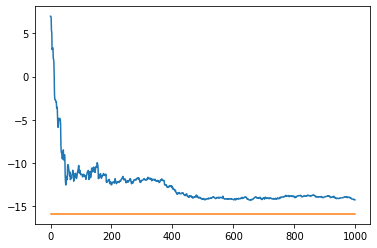

In [291]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)